In [25]:
import pandas as pd
#import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from eqUtils import *

from random import randint
import scipy.stats as ss

In [2]:
# mapping imports
import os
os.environ["PROJ_LIB"]='~/anaconda3/envs/earthquake-libcomcat/share/'
from mpl_toolkits.basemap import Basemap
import geopandas as gpd

## Parameters

Find all events within 100km of Lindsborg.
- latitude = 38.5735
- longitude = -97.6745

## Update history and read data

In [3]:
!python update-history.py
hist_df = pd.read_pickle('historyDF.pkl')
len(hist_df)

142

## Plot

### Time series

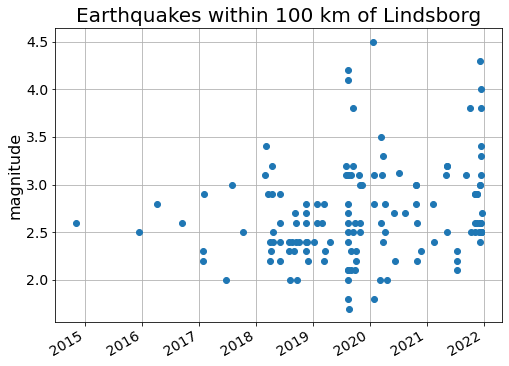

In [4]:
x = mdates.date2num(hist_df.index)
y = hist_df['magnitude']

fig_hist, ax = plt.subplots(figsize=(8,6))
plt.plot_date(x,y)
plt.gcf().autofmt_xdate()

plt.ylabel('magnitude', size=16)
plt.title('Earthquakes within 100 km of Lindsborg', size=20)
plt.grid()
ax.tick_params(axis='both', labelsize=14)

### Map

In [5]:
kansas = gpd.read_file('mapfiles/tl_2017_20_place.shp')

plotlat = hist_df['latitude'].to_numpy()
plotlong = hist_df['longitude'].to_numpy()
plotmag = hist_df['magnitude'].to_numpy()

Text(535000.0, 610000.0, 'Lindsborg')

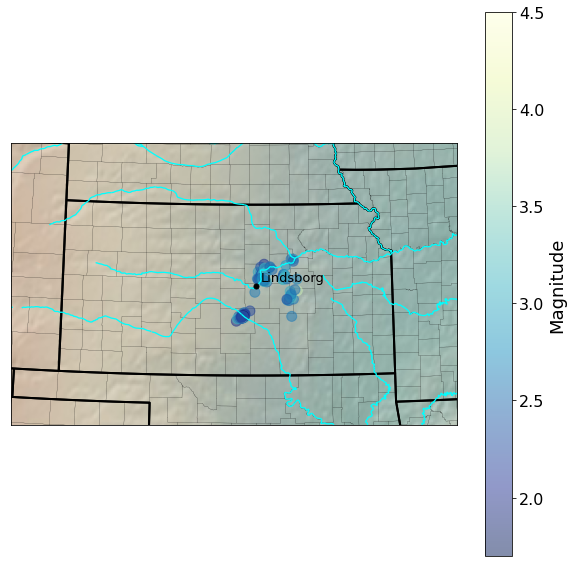

In [22]:
fig_map = plt.figure(figsize=(10, 10))
m = Basemap(projection='lcc', resolution='h',
            lat_0=38.5735, lon_0=-97.6745,
            width=1.05E6, height=1.2E6)
m.shadedrelief()
m.drawstates(linewidth=2)
m.drawcounties()
m.drawrivers(color='aqua', linewidth=1.3)

# extent in lat/lon (dec degrees)
ulx = -103
uly = 41
lrx = -93
lry = 36

# transform coordinates to map projection
xmin, ymin = m(ulx, lry)
xmax, ymax = m(lrx, uly)

# set the axes limits
ax = plt.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# add events
m.scatter(plotlong, plotlat, latlon=True,
          c=plotmag, s=100,
          cmap='YlGnBu_r', alpha=0.5)

# create colorbar
cb = plt.colorbar()
cb.set_label(label=r'Magnitude', size=18)
cb.ax.tick_params(labelsize=16)
plt.clim(plotmag.min(), plotmag.max())

# lindsborg
x,y = m(-97.6745,38.5735)
plt.plot(x,y, 'ok', markersize=5)
plt.text(x+10000,y+10000,'Lindsborg', fontsize=13)

## Develop running total

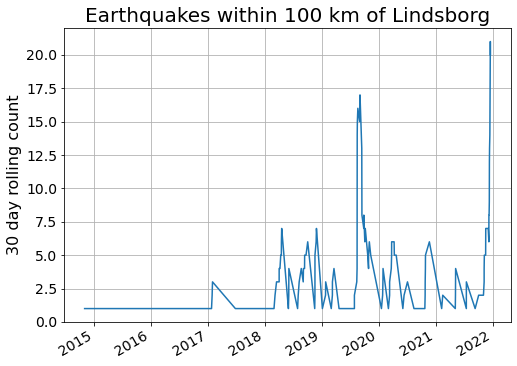

In [7]:
rolling_count = hist_df.sort_values(by=['time']).rolling('30d').count()

x = mdates.date2num(rolling_count.index)
y = rolling_count['magnitude']

fig_hist, ax = plt.subplots(figsize=(8,6))
plt.plot_date(x,y, '-')
plt.gcf().autofmt_xdate()

plt.ylabel('30 day rolling count', size=16)
plt.title('Earthquakes within 100 km of Lindsborg', size=20)
plt.grid()
ax.tick_params(axis='both', labelsize=14)

## Distribution by time
This data is interesting.  By the hour shows structure.   To see what random data should look like, we could do by minute or second.

Do some stats.  We need to generate a list of hour values for each of the earthquakes and then we can use histogram and do statistical tests.

KstestResult(statistic=0.130868544600939, pvalue=0.01398956909616828)

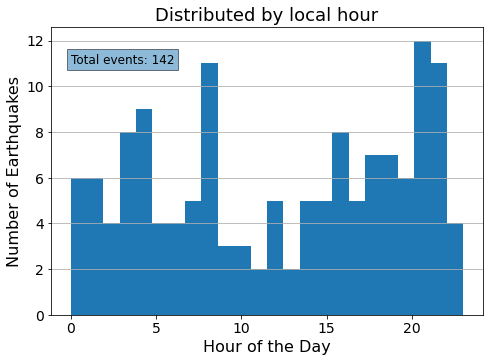

In [62]:
hour_distribution = np.asarray([x.hour for x in hist_df.index])

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
n, bins, _ = plt.hist(hour_distribution, bins=24)
ax.set_ylabel('Number of Earthquakes', size=16)
ax.set_xlabel('Hour of the Day', size=16)
ax.tick_params(axis='both', labelsize=14)
ax.grid(axis='y')
ax.set_title('Distributed by local hour', size=18)
plt.text(0, max(n)-1, 'Total events: '+str(len(hour_distribution)), bbox=dict(alpha=0.5), size=12)

ss.kstest(hour_distribution, ss.randint.cdf, args=(0,24))

#### Generate random hourly distribution for visual comparison

KstestResult(statistic=7.570422535211269e-02, pvalue=0.3712302630290616)

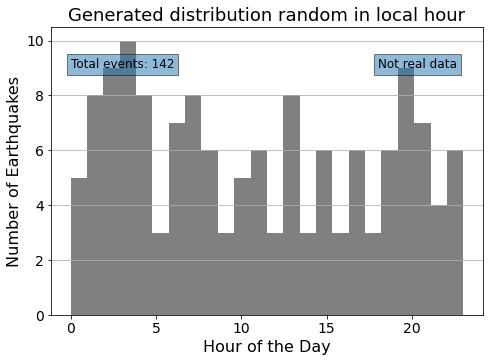

In [72]:
generated_list=np.random.randint(0,24,len(hist_df))
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
n, bins, _ = plt.hist(generated_list, bins=24, facecolor='gray')
ax.set_ylabel('Number of Earthquakes', size=16)
ax.set_xlabel('Hour of the Day', size=16)
ax.tick_params(axis='both', labelsize=14)
ax.grid(axis='y')
ax.set_title('Generated distribution random in local hour', size=18)
plt.text(0, max(n)-1, 'Total events: '+str(len(generated_list)), bbox=dict(alpha=0.5), size=12)
plt.text(max(bins)-5, max(n)-1, 'Not real data', bbox=dict(alpha=0.5), size=12)

ss.kstest(generated_list, ss.randint.cdf, args=(0,24))

KstestResult(statistic=6.76056338028169e-02, pvalue=0.5132579728358959)

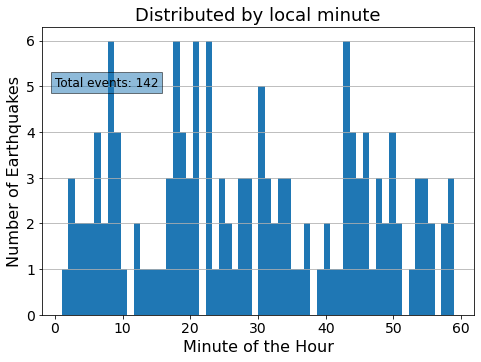

In [68]:
minute_distribution = np.asarray([x.minute for x in hist_df.index])

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
n, bins, _ = plt.hist(minute_distribution, bins=60)
ax.set_ylabel('Number of Earthquakes', size=16)
ax.set_xlabel('Minute of the Hour', size=16)
ax.tick_params(axis='both', labelsize=14)
ax.grid(axis='y')
ax.set_title('Distributed by local minute', size=18)
plt.text(0, max(n)-1, 'Total events: '+str(len(minute_distribution)), bbox=dict(alpha=0.5), size=12)

ss.kstest(minute_distribution, ss.randint.cdf, args=(0,60))

KstestResult(statistic=5.0938967136150204e-02, pvalue=0.8363272220579767)

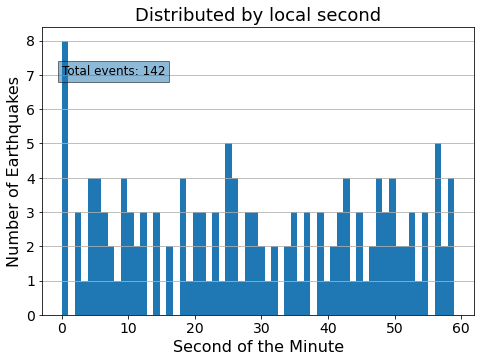

In [69]:
second_distribution = np.asarray([x.second for x in hist_df.index])

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
n, bins, _ = plt.hist(second_distribution, bins=60)
ax.set_ylabel('Number of Earthquakes', size=16)
ax.set_xlabel('Second of the Minute', size=16)
ax.tick_params(axis='both', labelsize=14)
ax.grid(axis='y')
ax.set_title('Distributed by local second', size=18)
plt.text(0, max(n)-1, 'Total events: '+str(len(second_distribution)), bbox=dict(alpha=0.5), size=12)

ss.kstest(second_distribution, ss.randint.cdf, args=(0,60))

## Data Analysis

In [136]:
pd.pivot_table(hist_df, index=hist_df.index.date, columns=hist_df.index.hour, values='magnitude').stack()

            time
2014-11-03  4       2.6
2015-12-14  16      2.5
2016-04-04  7       2.8
2016-09-14  22      2.6
2017-01-24  23      2.2
                   ... 
2021-12-16  18      2.5
2021-12-17  8       3.3
            14      2.5
            19      2.6
2021-12-18  9       2.7
Length: 135, dtype: float64

In [137]:
pd.pivot_table(hist_df, index=hist_df.index.date, values='magnitude').stack()

2014-11-03  magnitude    2.6
2015-12-14  magnitude    2.5
2016-04-04  magnitude    2.8
2016-09-14  magnitude    2.6
2017-01-24  magnitude    2.2
                        ... 
2021-12-14  magnitude    2.5
2021-12-15  magnitude    3.5
2021-12-16  magnitude    2.5
2021-12-17  magnitude    2.8
2021-12-18  magnitude    2.7
Length: 105, dtype: float64

In [171]:
xx = pd.DataFrame(hist_df.groupby(hist_df.index.hour).count())['magnitude']

In [172]:
xx

time
0      6
1      6
2      4
3      8
4      9
5      4
6      4
7      5
8     11
9      3
10     3
11     2
12     5
13     2
14     5
15     5
16     8
17     5
18     7
19     7
20     6
21    12
22    11
23     4
Name: magnitude, dtype: int64